__Author: Marcio Ribeiro__

## Introduction 
This Notebook was developed based on the [Diabetes 130-US hospitals for years 1999-2008 Data Set](https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008#).
The dataset contains clinical data from 130 Us hospitals collected between 1999 and 2008 from patients with Diabetes.  
The notebook encompasses a pipeline which includes Data Exploration, Model Development and Model Accuracy Analysis.

Labels contained in the dataset are the following: 

1. No readmission  
2. Readmission in less than 30 days  
3. Readmission in more than 30 days  

I have decided to merge the labels 1 and 3 into one, so that the problem becomes a binary classification.

The are two main factors for this choice:
- To remove ambiguity between labels: Since labels 2 and 3 represent the event in which a patient was readmitted. The difference between a patient readmitted 29 days after discharge and one that was readmitted after 31 days will likekly be small, so I've decided to create a single label for both scenarios.
- Tackling the actual problem: There are many factors that could've influenced a patient to go back to the hospital after more than 30 days have passed, thus it's difficult to tell if the treatment given was the ineffective. 

Which lead us to the main objective, **predict whether a patient will be readmitted in a window of 30 days after being discharged**.    

As an additional source of information regarding this dataset there is [this article](https://www.hindawi.com/journals/bmri/2014/781670/) which explores a bit more on how it was collected and the details about each of the features available.

In [1]:
# install dependencies
!pip install icd9cms lightgbm

In [2]:
# download dataset to current workdir
dataset_file = 'dataset_diabetes.zip'
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00296/dataset_diabetes.zip -O $dataset_file

--2020-10-06 20:25:27--  https://archive.ics.uci.edu/ml/machine-learning-databases/00296/dataset_diabetes.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3347213 (3.2M) [application/x-httpd-php]
Saving to: ‘dataset_diabetes.zip’

dataset_diabetes.zi 100%[===================>]   3.19M  2.00MB/s    in 1.6s    

2020-10-06 20:25:30 (2.00 MB/s) - ‘dataset_diabetes.zip’ saved [3347213/3347213]



In [3]:
# extract dataset zip
!unzip dataset_file -y

Archive:  dataset_file
caution: filename not matched:  -y


In [4]:
# import libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, auc, roc_curve
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [5]:
# ignore pandas warnings (use with caution)
import warnings
warnings.filterwarnings("ignore")

In [6]:
# set matplotlib plot size
plt.rcParams["figure.figsize"] = (10, 5)

In [7]:
# load dataset
data = pd.read_csv('dataset_diabetes/diabetic_data.csv')

# IDS_mappings.csv is actually three different column mappings into one, so it must be read separately
# also each attribute already has it's own NULL assignment
admission_type_id = pd.read_csv('dataset_diabetes/IDs_mapping.csv', nrows=8, keep_default_na=False)
discharge_disposition_id = pd.read_csv('dataset_diabetes/IDs_mapping.csv', skiprows=10, nrows=30, keep_default_na=False)
admission_source_id = pd.read_csv('dataset_diabetes/IDs_mapping.csv', skiprows=42, nrows=27,  keep_default_na=False)

Before moving forward, now is a good time to apply the changes to the dataset labels mentioned in the Introduction section.

In [8]:
# for all instances of readmission ">30", change to "NO".
# this effectively merges the two labels
data.loc[data['readmitted']==">30", 'readmitted'] = "NO"

Below is a description and data type of the features available in the dataset. [Source](https://www.hindawi.com/journals/bmri/2014/781670/)

<img src="diabetes_dataset_features.jpg">

Create copy of data to be used on EDA

In [9]:
data_copy = data.copy(deep=True)

Before continuing, some categorical variables are already label-encoded which is great for the modeling phase but not so much during EDA.  
Cell below will join feature values based on ids so that their strings description can be obtained.

In [10]:
# iterate over each column, merge with proper description df and add description instead of label
label_encoded_columns = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']

for column in label_encoded_columns:
    data_copy = data_copy.merge(eval(column), left_on=column, right_on=column)
    data_copy[column] = data_copy.pop('description')

# EDA

Next step is to analyze features available and also learn more about the problem and data available. Later this knowledge will come in handy during the modeling phase to help understand model performance and it can be improved by preprocessing the data. After checking the white-paper listed on the dataset page, it's clear many variables are related and need to be explored that way. Also any inconsistencies found during EDA will be applied to the data so that when the Modeling stage is reached the data is mostly ready.

#### readmitted

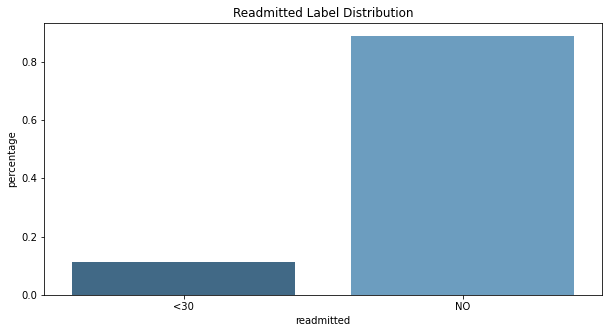

In [11]:
# plot readmitted distribution
data_plot = data_copy['readmitted'].value_counts(sort=False, normalize=True)
data_plot = pd.DataFrame(data_plot).reset_index().rename({"index": "readmitted", "readmitted": "percentage"}, axis=1)
sns.barplot(x='readmitted',
            y="percentage", 
            data=data_plot,
            palette="Blues_d")
plt.title("Readmitted Label Distribution")
plt.show()

Above chart shows the proportion of the labels in the dataset after updating the labels.

#### patient_nbr

In [12]:
# check if the there is more than one entry for any given patient
patient_freq = data_copy.groupby('patient_nbr').count()
print("There are {} patients with more than one entry in the dataset".format(patient_freq[patient_freq>1].any().sum()))

There are 49 patients with more than one entry in the dataset


#### race

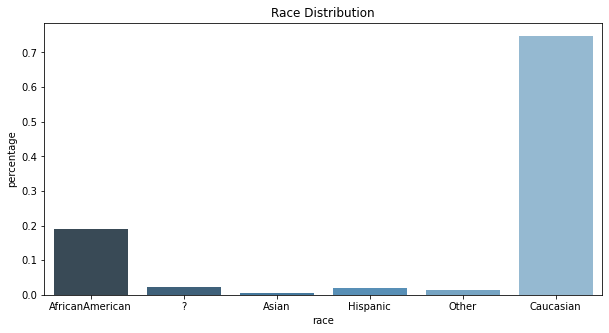

In [13]:
# plot race distribution
data_plot = data_copy['race'].value_counts(sort=False, normalize=True)
data_plot = pd.DataFrame(data_plot).reset_index().rename({"index": "race", "race": "percentage"}, axis=1)
sns.barplot(x='race',
            y="percentage", 
            data=data_plot,
            palette="Blues_d")
plt.title("Race Distribution")
plt.show()

When looking at this particular feature, the distribution is very imbalanced towards entries for Caucasians and also the "?" symbol is used for representing missing values, which is fine since its already label encoded in the original data.

#### gender

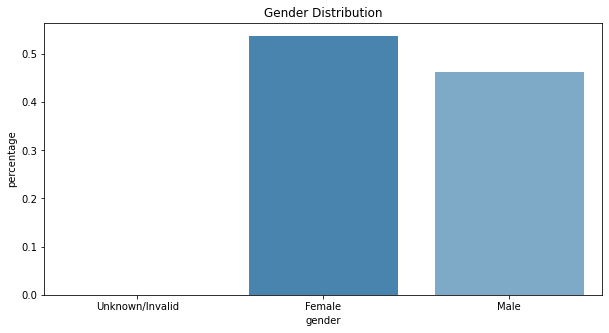

In [14]:
# plot gender distribution
data_plot = data_copy['gender'].value_counts(sort=False, normalize=True)
data_plot = pd.DataFrame(data_plot).reset_index().rename({"index": "gender", "gender": "percentage"}, axis=1)
sns.barplot(x='gender',
            y="percentage", 
            data=data_plot,
            palette="Blues_d")
plt.title("Gender Distribution")
plt.show()

#### age

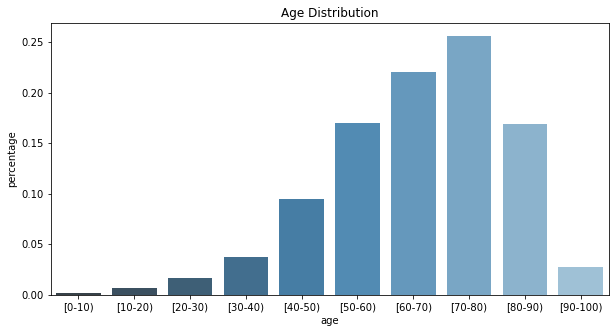

In [15]:
# plot age distribution

# create bins
ordering = ["[0-10)", "[10-20)", "[20-30)", "[30-40)", "[40-50)", "[50-60)", "[60-70)", "[70-80)", "[80-90)", "[90-100)"]

data_plot = data_copy['age'].value_counts(sort=False, normalize=True)
data_plot = pd.DataFrame(data_plot).reset_index().rename({"index": "age", "age": "percentage"}, axis=1)
sns.barplot(x='age',
            y="percentage",
            data=data_plot,
            order=ordering,
            palette="Blues_d")
plt.title("Age Distribution")
plt.show()

Since the dataset is for hospital admission for diabete cases, this plot shows that number of admission grows with age.  
One interesting thing that can be seen is that the two last groups have lower numbers than the ones before. There is no reason to believe that people more than 80 years old have a lower chance of having diabetes than the groups before. Rather this happens given the nature of the dataset (human lives longevity). 

#### weight

In [16]:
print("Entries where no info is available on weight column: {}".format(len(data[data['weight']!='?'])))

Entries where no info is available on weight column: 3197


For the weight column, only about 3200 of the 100K+ rows have valid entries, making it not very useful in practice. Cell below will drop weight column from data.

In [17]:
data.drop('weight', axis=1, inplace=True)

#### admission_type

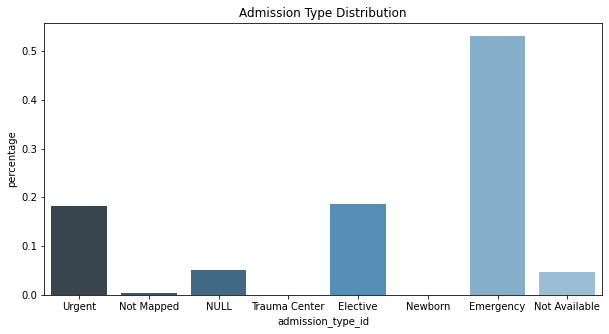

In [18]:
# plot admission_type distribution
data_plot = data_copy['admission_type_id'].value_counts(sort=False, normalize=True)
data_plot = pd.DataFrame(data_plot).reset_index().rename({"index": "admission_type_id", "admission_type_id": "percentage"}, axis=1)
sns.barplot(x='admission_type_id',
            y="percentage", 
            data=data_plot,
            palette="Blues_d")
plt.title("Admission Type Distribution")
plt.show()

By far the most common admission type in the dataset is of the Emergency type. Also there are some that were not mapped at all and those occurrencies will be fixed by mapping "NULL" and "Not Available" to "Not Mapped"

In [19]:
# assign all different missing entries to "Not Mapped"
data.loc[data['admission_type_id']==5, 'admission_type_id'] = 8
data.loc[data['admission_type_id']==6, 'admission_type_id'] = 8

#### discharge_disposition

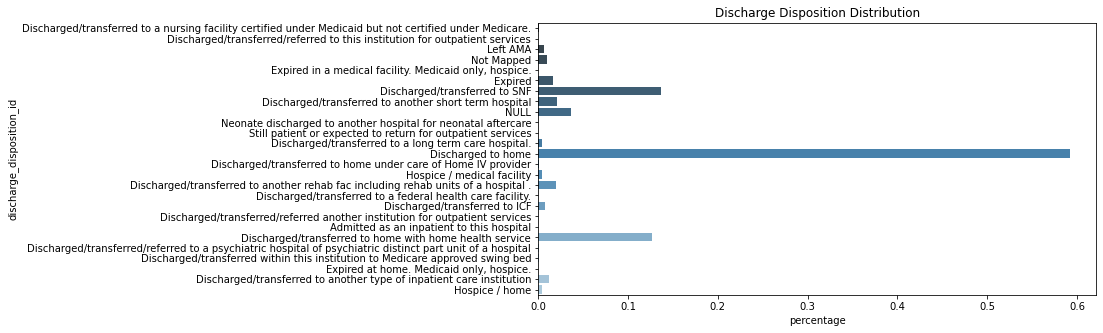

In [20]:
# plot discharge_disposition_id distribution
data_plot = data_copy['discharge_disposition_id'].value_counts(sort=False, normalize=True)
data_plot = pd.DataFrame(data_plot).reset_index().rename({"index": "discharge_disposition_id", "discharge_disposition_id": "percentage"}, axis=1)
sns.barplot(y='discharge_disposition_id',
            x="percentage", 
            data=data_plot,
           orient="h",
            palette="Blues_d")
plt.title("Discharge Disposition Distribution")
plt.show()

From the chart, we can see that the majority of patients are sent back home while some entries are recorded as "NULL", and it also has "Not Mapped". Let's map those entries to the same label:

In [21]:
# assign all different missing entries to "Not Mapped"
data.loc[data['discharge_disposition_id']==18, 'discharge_disposition_id'] = 25
data.loc[data['discharge_disposition_id']==26, 'discharge_disposition_id'] = 25

#### admission_source

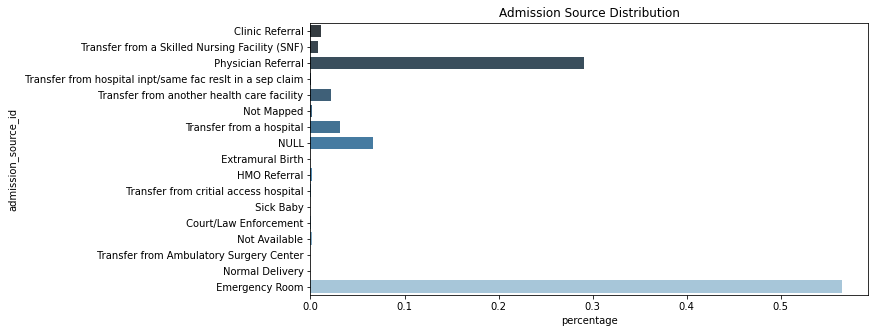

In [22]:
# plot discharge_disposition_id distribution
data_plot = data_copy['admission_source_id'].value_counts(sort=False, normalize=True)
data_plot = pd.DataFrame(data_plot).reset_index().rename({"index": "admission_source_id", "admission_source_id": "percentage"}, axis=1)
sns.barplot(y='admission_source_id',
            x="percentage", 
            data=data_plot,
           orient="h",
            palette="Blues_d")
plt.title("Admission Source Distribution")
plt.show()

The majority of patients were received in the Emergency Room, which makes sense once compared to the "Admission Type" feature, which has Emergency as the one with the highest incidence. Similarly to previous variables, it also has cases where the information was not recorded and thus, it's represented by "NULL".  
Also, "NULL", "Not Mapped", "Unknown/Invalid" and "Not Available" are present in the dataset, they all will be changed to "Not Mapped".

In [23]:
# assign all different missing entries to "Not Mapped"
data.loc[data['admission_source_id']==9, 'admission_source_id'] = 20
data.loc[data['admission_source_id']==15, 'admission_source_id'] = 20
data.loc[data['admission_source_id']==17, 'admission_source_id'] = 20
data.loc[data['admission_source_id']==21, 'admission_source_id'] = 20

#### time_in_hospital

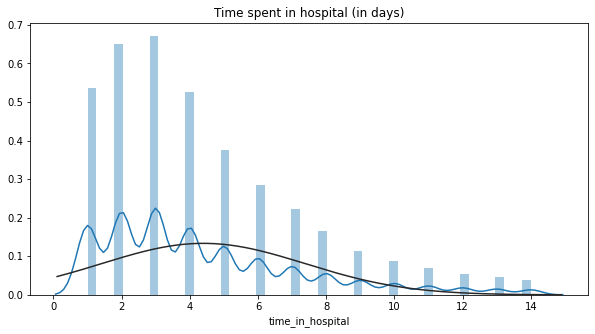

In [24]:
sns.distplot(data_copy['time_in_hospital'], fit=norm)
plt.title("Time spent in hospital (in days)")
plt.show()

In this dataset, all patients were in the hospital between 1 and 14 days 

#### payer_code

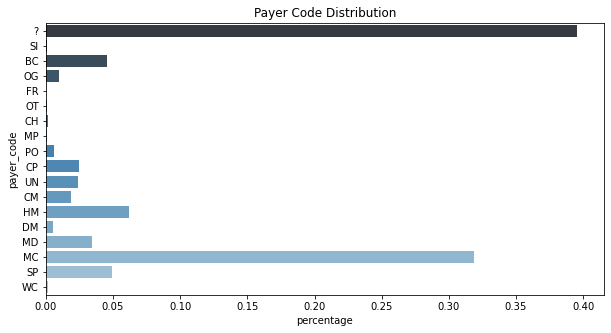

In [25]:
# plot payer_code distribution
data_plot = data_copy['payer_code'].value_counts(sort=False, normalize=True)
data_plot = pd.DataFrame(data_plot).reset_index().rename({"index": "payer_code", "payer_code": "percentage"}, axis=1)
sns.barplot(y='payer_code',
            x="percentage", 
            data=data_plot,
           orient="h",
            palette="Blues_d")
plt.title("Payer Code Distribution")
plt.show()

This column indicates the payment method used on hospital checkout. Nearly 40% of entries are mapped as unknown ("?").

#### medical_specialty

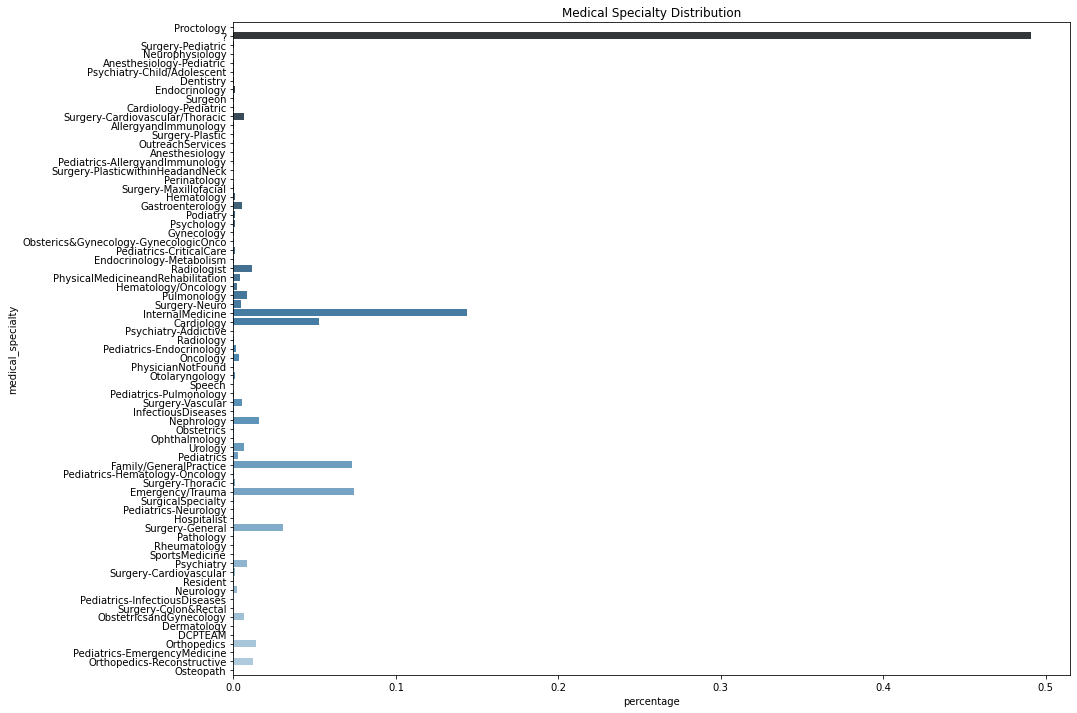

In [26]:
# plot medical_specialty distribution
data_plot = data_copy['medical_specialty'].value_counts(sort=False, normalize=True)
data_plot = pd.DataFrame(data_plot).reset_index().rename({"index": "medical_specialty", "medical_specialty": "percentage"}, axis=1)
plt.figure(figsize=(15,12))
plt.tight_layout()
sns.barplot(y='medical_specialty',
            x="percentage", 
            data=data_plot,
           orient="h",
            palette="Blues_d")
plt.title("Medical Specialty Distribution")
plt.show()

Once again half of observations don't have this information filled in, representing it as "?". Also, even for the cases where the data is available it is considerably sparse, most medical specialties have very few entries.

#### numerical columns

This section is for visualizing the numerical columns available in the dataset

In [27]:
numerical_columns =  ['num_lab_procedures', 'num_procedures', 'num_medications', 
                      'number_outpatient', 'number_inpatient', 'number_emergency', 
                      'number_diagnoses']

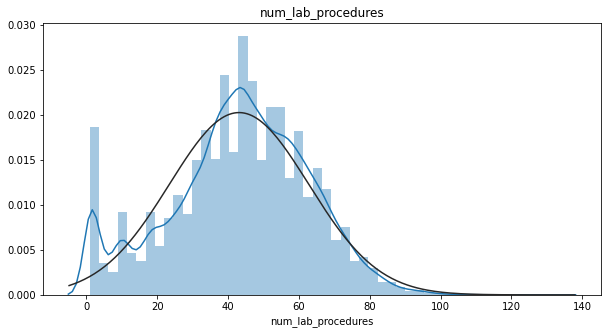

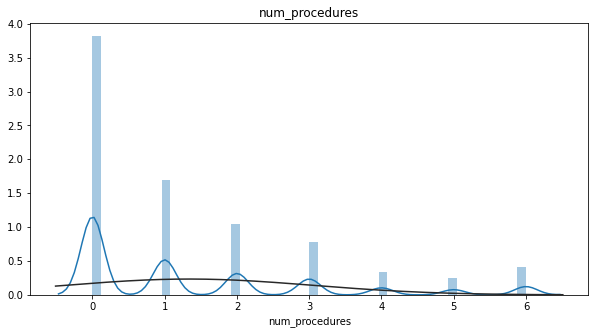

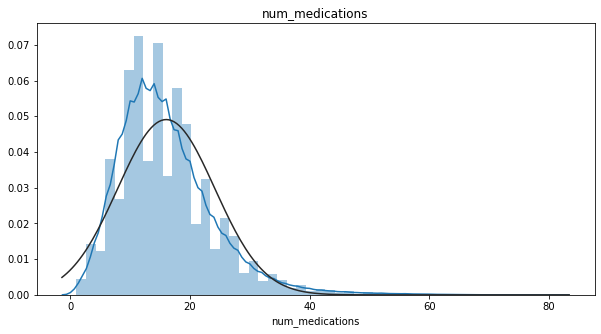

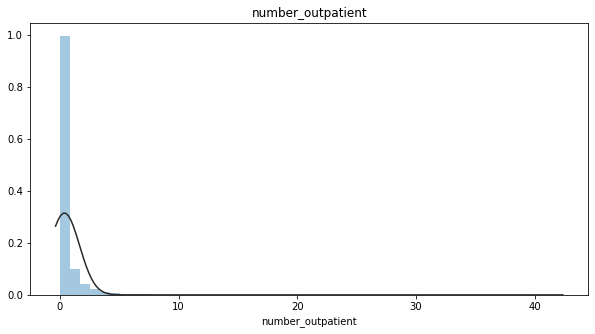

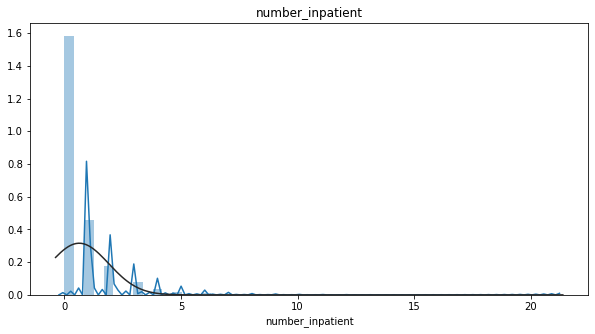

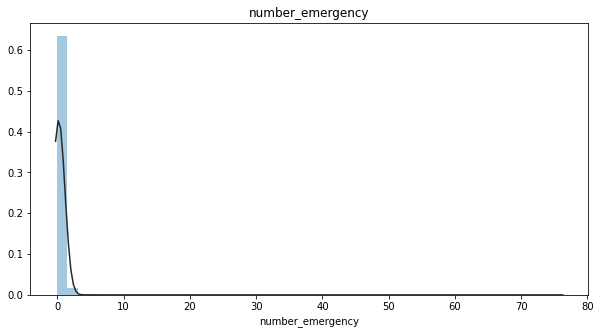

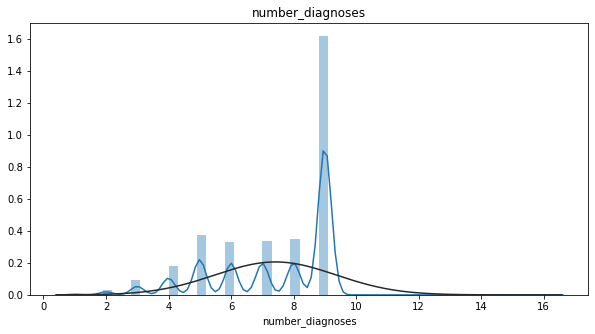

In [28]:
# plot numerical columsn
for column in numerical_columns:
    sns.distplot(data_copy[column], fit=norm)
    plt.title(column)
    plt.show()

Most of the frequency-related features above have outliers, some more than others. This will need to be kept in mind during the modeling phase.

#### diag_1/diag_2/diag_3

These features for diagnoisis are fairly complex and difficult to be used in their current state. They represent a code for the disease type that the patient was diagnosed and the codes are structured so that similar health problems are grouped together. Before using them in a model it would be a good idea to somehow parse all the codes and get to the root branch of each disease.

For example, code 785 and all in between 390 and 459 are for Circulatory diseases. There are some Python libraries with code lookups for this data, here the [icd9cms](https://pypi.org/project/icd9cms/) will be used.

Cell below will transform all disease codes into their parent code, which is a way to reduce the high cardinality that these features have (from 800+ to 100+ unique entries)

In [29]:
from icd9cms.icd9 import search

# diagnosis data columns
diagnosis_columns = ['diag_1', 'diag_2', 'diag_3']

# iterate over each column
for column in diagnosis_columns:
    # itera over each dataframe row
    for index, row in data.iterrows(): 
        # get the code definition from icd9cms
        diagnosis = search(row[column]) 
        # check if it exists in the table and
        if diagnosis:
            # if it exists, get the parent code
            diagnosis_n = str(diagnosis.parent).split(':')[0]
        else:
            # if it doesn't exist, assign unknown
            diagnosis_n = "Unknown"
        # add value to DataFrame
        data.at[index, column] = diagnosis_n

In [30]:
data['diag_1']

0            2508
1         270-279
2         640-649
3         Unknown
4         190-199
           ...   
101761       2501
101762    560-569
101763    Unknown
101764    996-999
101765    530-539
Name: diag_1, Length: 101766, dtype: object

#### max_glu_serum

In [31]:
data['max_glu_serum'].value_counts()

None    96420
Norm     2597
>200     1485
>300     1264
Name: max_glu_serum, dtype: int64

This column indicates the result for a specific test, altough the ratio of missing values is too high, making it unusable in practice. The cell below will drop it from the data

In [32]:
data.drop('max_glu_serum', axis=1, inplace=True)

#### A1Cresult

In [33]:
data['A1Cresult'].value_counts()

None    84748
>8       8216
Norm     4990
>7       3812
Name: A1Cresult, dtype: int64

Similarly to the previous column, this also indicates result for a specific test with many missing entries.  The cell below will drop it from the data

In [34]:
data.drop('A1Cresult', axis=1, inplace=True)

#### change

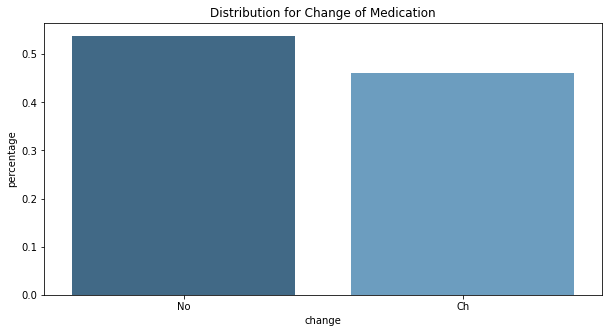

In [35]:
# plot change distribution
data_plot = data_copy['change'].value_counts(sort=False, normalize=True)
data_plot = pd.DataFrame(data_plot).reset_index().rename({"index": "change", "change": "percentage"}, axis=1)
sns.barplot(x='change',
            y="percentage", 
            data=data_plot,
            palette="Blues_d")
plt.title("Distribution for Change of Medication")
plt.show()

Indicates if there was any change in the medication being taken by the patient.

#### diabetesMed

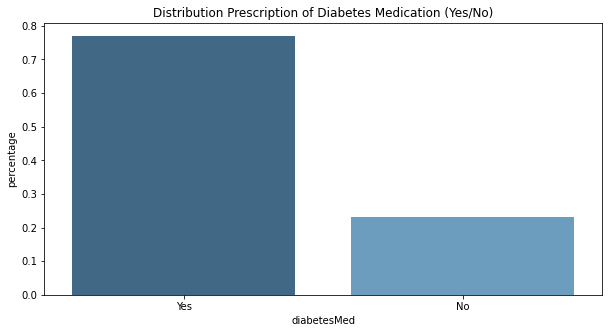

In [36]:
# plot diabetesMed distribution
data_plot = data_copy['diabetesMed'].value_counts(sort=False, normalize=True)
data_plot = pd.DataFrame(data_plot).reset_index().rename({"index": "diabetesMed", "diabetesMed": "percentage"}, axis=1)
sns.barplot(x='diabetesMed',
            y="percentage", 
            data=data_plot,
            palette="Blues_d")
plt.title("Distribution Prescription of Diabetes Medication (Yes/No)")
plt.show()

Shows if the patient received a prescription for diabetes medication.

#### medication-specific columns

This 23 columns are used to indicate what actions were made regarding each specific drug to each patient.

In [37]:
medication_columns = ['metformin', 'repaglinide', 
                      'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 
                      'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
                      'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
                      'examide', 'citoglipton', 'insulin', 'glyburide-metformin',
                      'glipizide-metformin', 'glimepiride-pioglitazone',
                      'metformin-rosiglitazone', 'metformin-pioglitazone']

In [38]:
# check all unique values within all medication_columns
unique_values = set()

# iterate over each medication column 
for column in medication_columns:
    # get unique values in column
    unique_iter = set(data[column].unique())
    
    # add to set
    unique_values.update(unique_iter)

In [56]:
print("Unique entries for medication-specific features: {}".format(unique_values))

Unique entries for medication-specific features: {'Up', 'Down', 'Steady', 'No'}


For all there are four possible entries, indicating if the dosage was changed or if the medication not prescribed at all. This columns will be preprocessed later to be tested in a model

# Modeling

Now the model will be developed, there are nearly 50 features that can be categorical or numerical, which makes tree-based algorithms a very interesting option. The model here will be Gradient Boosting Machine, more specifically, the [LightGBM](https://lightgbm.readthedocs.io/en/latest/) implementation.  
Before feeding the data to the model, there are a few preprocessing steps that are needed:

#### Label Encode String Categorical

Below the columns which contain string values will be processed using sklearn's LabelEncoder to transform them to a integer format that can be used by the algorithm

In [40]:
# The list of columns below need to be encoded with a LabelEncoder since their values are strings
string_categorical_cols = ['readmitted', 'race', 'gender', 'age', 'medical_specialty', 'payer_code', 'diag_1', 'diag_2', 'diag_3', 'change', 'diabetesMed']

# create one LabelEncoder for each column, transform the data and save the LE in a dict
label_encoder_dict = {}
for column in string_categorical_cols:
    lb = LabelEncoder()
    data[column] = lb.fit_transform(data[column])
    label_encoder_dict[column] = lb

The medication columns will also be processed similarly, since they all contain the same labels, a single encoder will suffice.

In [41]:
# create one LabelEncoder for each column, transform the data and save the LE in a dict
lb = LabelEncoder()
lb.fit(data[medication_columns[0]])

for column in medication_columns:
    data[column] = lb.transform(data[column])
    label_encoder_dict[column] = lb

#### Splitting the Dataset

The dataset will be split into 70/30 for Train and Test

In [42]:
# split data

# columns not to include for training
columns_to_ignore = ['encounter_id', 'patient_nbr', 'readmitted']

X = data.loc[:, ~data.columns.isin(columns_to_ignore)]
y = data['readmitted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=33)

In [43]:
# create Dataset object, used by LGBM for optimal performance
train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)

#### Model

In [44]:
data.groupby('readmitted').count()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
readmitted,,,,,,,,,,,,,,,,,,,,,
0,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,...,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357
1,90409,90409,90409,90409,90409,90409,90409,90409,90409,90409,...,90409,90409,90409,90409,90409,90409,90409,90409,90409,90409


In [45]:
# set model params

# calculate class imbalancing between the labels
scale_pos_weight =  len(data_copy[data_copy['readmitted']=="<30"]) / len(data_copy[data_copy['readmitted']=="NO"])

# set model params
params = {'objective': 'binary', 
          'metric': 'binary_logloss',
          'is_unbalance': False,
          'max_bin': 255,
          'num_leaves': 31,
          'learning_rate': 0.1,
          'scale_pos_weight': scale_pos_weight}
num_round = 300

In [46]:
# trian model
model = lgb.train(params, train_set=train_data, num_boost_round=num_round)

[LightGBM] [Info] Number of positive: 63300, number of negative: 7936
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 846
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.888596 -> initscore=2.076476
[LightGBM] [Info] Start training from score 2.076476


In [47]:
# generate predictions on test data
forecast = model.predict(X_test)

# get labels for the highest probability label at each row
threshold = 0.50
forecast = (forecast >= threshold).astype(np.int)

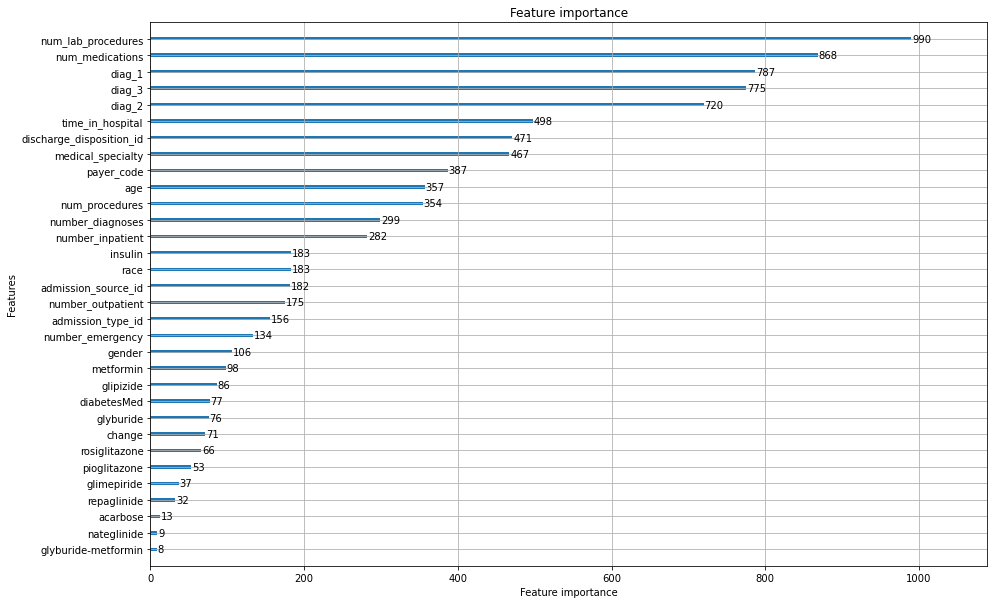

In [48]:
# plot feature importance
lgb.plot_importance(model, figsize=(15,10))

When looking at the feature importance, number of lab procedures performed, number of medications taken and what where the diagnosis given by the doctors took the lead here. Not surprisingly, the medications were not very helpful, except for insulin which makes sense.

# Model Performance

In [49]:
# measure model performance
target_names = ['<30', 'NO']
print(classification_report(y_test, forecast, target_names=target_names))

              precision    recall  f1-score   support

         <30       0.19      0.50      0.27      3421
          NO       0.92      0.72      0.81     27109

    accuracy                           0.70     30530
   macro avg       0.55      0.61      0.54     30530
weighted avg       0.84      0.70      0.75     30530



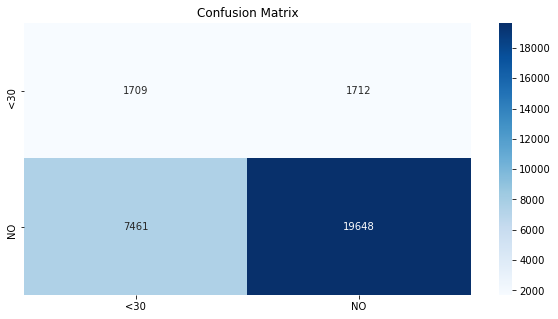

In [50]:
# plot confusion matrix heatmap
sns.heatmap(confusion_matrix(y_test, forecast), annot=True, cmap='Blues', fmt='g', xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.show()

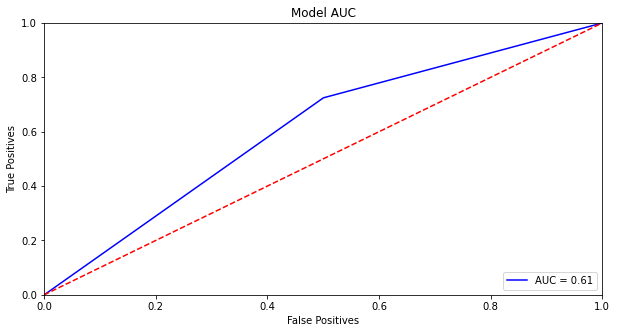

In [57]:
# get ROC and AUC
fpr, tpr, threshold = roc_curve(y_test, forecast)
roc_auc = auc(fpr, tpr)

# plot ROC Curve
plt.title('Model AUC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positives')
plt.xlabel('False Positives')
plt.show()

- The model achieved an AUC of 61% and an Accuracy of 70%, since the dataset has the labels unbalanced almost 10 to 1 these results aren't that surprising. 
- When looking at the Confusion Matrix, the model captured about 50% of the labels for the unbalanced class correctly while generating the same amount as False Positives. For this particular task, False Positives are not as expensive as False Negatives since it's more important to correctly predict if a patient will return than the other way around.